Importing libraries

In [68]:
from utility import *
import cv2
import numpy as np

%reload_ext autoreload
%autoreload 2
%matplotlib inline


Loading the video. 
`rgb` flag defines whether we would like to use RGB images (`True`) or Grayscale images (`False`)

In [69]:
path_to_video = 'video/baby.mp4' 
video, fps = load_video(path_to_video, rgb = False)

Loading video/baby.mp4


Properties of the video

In [70]:
num_frames, width, height, fps = get_video_info(path_to_video)

The number of frames is: 301
The resolution of the video is: 544x960
Frames per second: 30


Extracting an image from the video

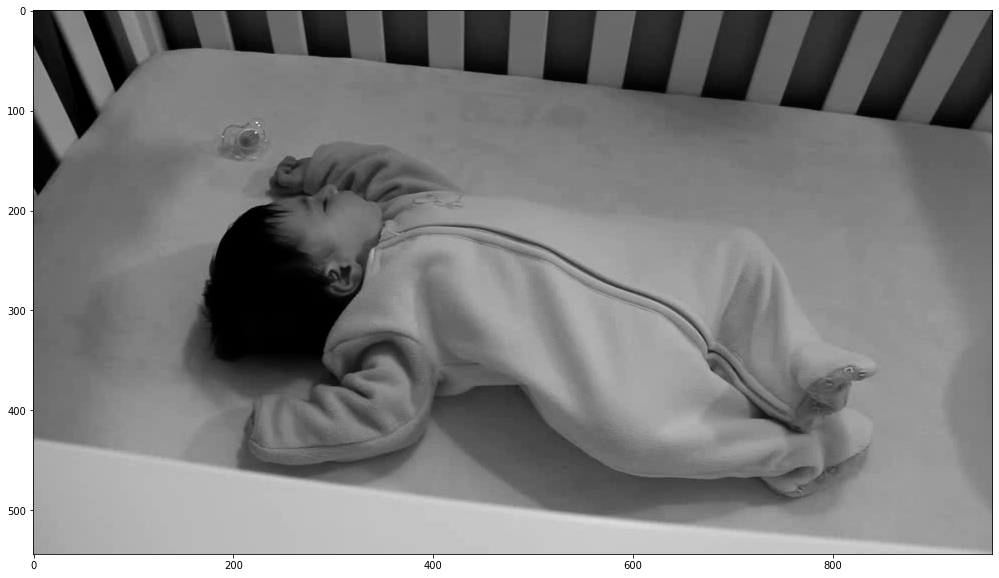

In [71]:
image = video[0].copy() #taking the first frame
show_image_nb(image)

Showing layers of Laplacian or Gaussian pyramid.
Laplacian pyramid is used in linear-based approach.

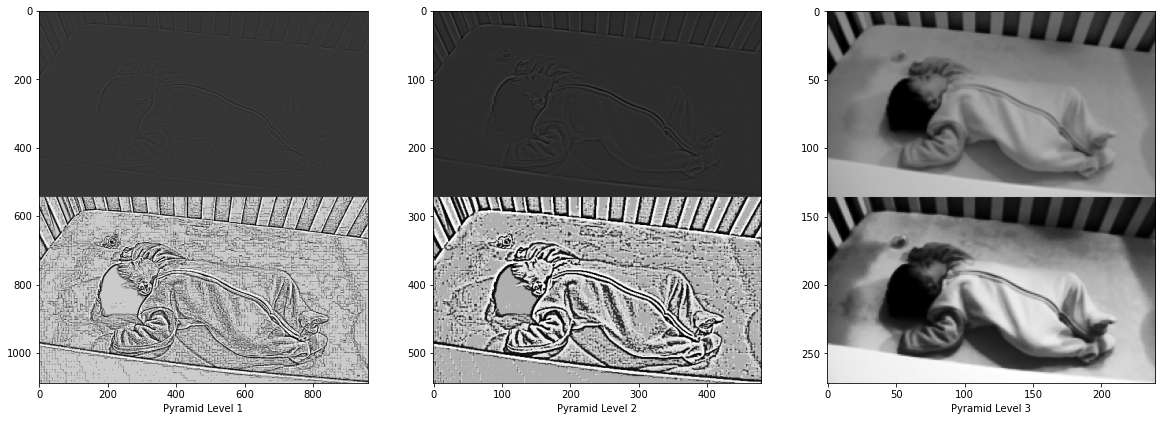

In [72]:
plot_pyramid(image, pyramid_levels = 3, pyramid = 'laplacian')
#Upper image is originally extracted image, lower image is when histogram equalization is applied (for visualisation purposes)

Choosing a Region Of Interest (ROI)

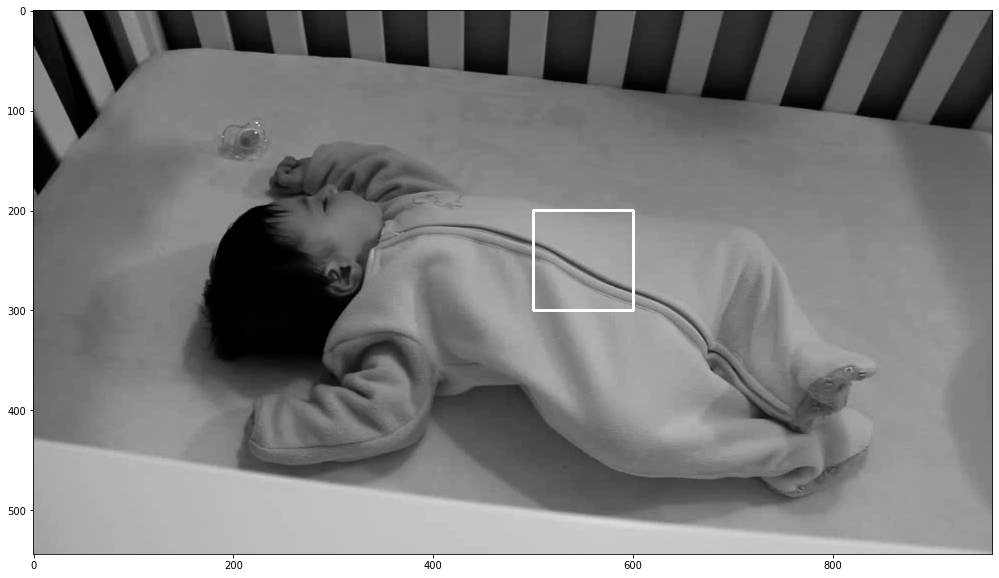

In [73]:
square_coords = {'x1':200, 'x2': 300, 'y1':500, 'y2':600} 
draw_roi_nb(image, square_coords)

Extracting ROI as separate video (OPTIONAL)

Motion magnification tecniques are memory demanding and the easiest way to go around this issue
 is to crop the video by choosing the ROI and/or to use grayscale images(`rgb=False`) when we load it
extract_roi_video(video, 'video_results/cropped_video.avi', fps, square_coords)

In [ ]:
extract_roi_video(video, 'video_results/cropped_video.avi', fps, square_coords)

FFT of the image and ROI(ROI is optional; if you do not want to show ROI fft, set `square_coords=None`)

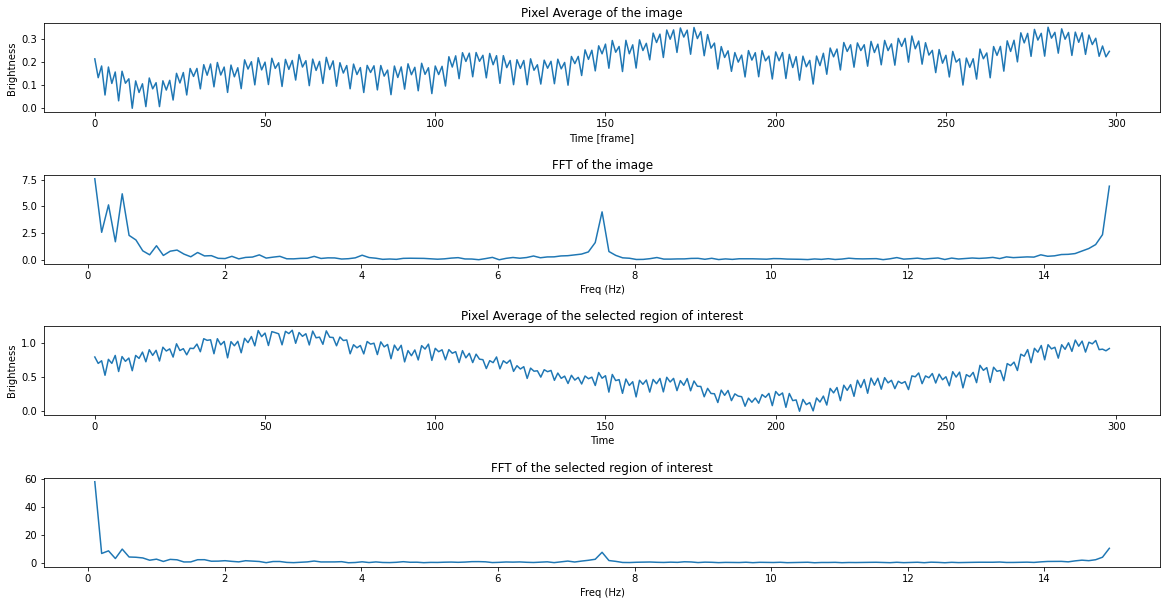

In [74]:
show_frequencies(video[:], fps, square_coords=square_coords)

#NOTE: sometimes it's better to pass subarray: video[x:y]. The reason is that for some videos
#      the brightness value drops before the video ends so the average of the pixel values looks like the inverse step function, like this: ‾‾‾‾|__
#      so it messes up the fft. For instance, this happens for the 'auto' footage.

Calculating frequency grid

We split the video into equidistant regions (boxes/subvideos) with the total resolution of `factor` x `factor`. We calculate FFT for every box.

Higher the `factor`, better the resolution but also longer computation time.

In [75]:
freqs, grid = create_grid(video, fps, factor = 128)

Now we set the `frequency` for which we would like to see spatial 'presence'. Since the frequencies are discrete, we cannot guarante that there is that specific value so we access some points around that value and average over them. More precisely, we calculate a `resolution` and we average over the `-number_of_pts*resolution` to `+numbe_of_pts*resolution`.

For example, if we would like to see the presence of `frequency = 5` and the `resolution` is calculated to be `0.22`, if we set the `number_of_pts = 3` the range of frequencies would be from `4.34Hz` to `5.66Hz` and we see what discrete frequencies we have defined within that range and average the FFT magnitude over them. This also gives a way to manually set the range. 


In [76]:
resolution = (fps/2)/len(freqs)
print(resolution)

0.1


`vmax` sets the maximum to which the coloring is scaled. Since the grid is normalzied, theoretically maximum is 1 but in practice it is much much lower. 

If this is set to `None` the color will *always* scale to the maximum amplitude. This can be misleading since it will always show color yellow for regions with higher magnitudes even though the magnitude itself is not high. So we would have to look at the values on the colorbar to infere whether that frequency is present. Example: for the baby sequence, for `frequency = 1`, we can clearly see the frequencies are located on the baby'b belly. But if we set `frequency = 5`, we would also see yellow region on the baby's belly **BUT** the magnitude is much much lower because we don't really have that frequency.

If we set the number, we always scale the color to that maximum number.

*How I use it:*

*For the baby video, I know that the frequency of breathing is around 1Hz so I set `frequency = 1` and I set the `vmax = None` and see the magnitudes besides the colorbar (the maximum is around 0.35) so from now on I use `vmax = 0.35` since I know that if the **main** frequency has that maximum, others can only have less. And now if we set `frequuency = 5`, we would see that there are no significant regions with that frequency as we should.*

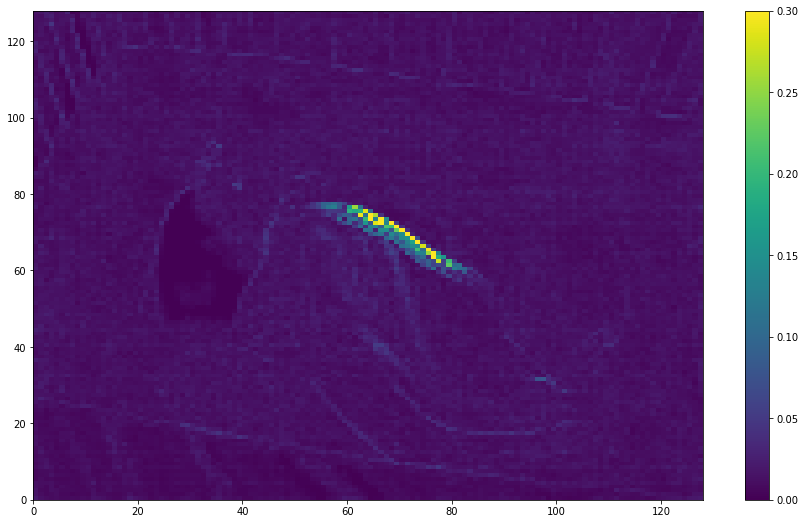

In [77]:
frequency_grid(grid, freqs, fps, frequency = 1, number_of_pts = 4, vmax = 0.3)

## Optical flow




#### The grid of motion vectors

`step` determines the distance between the points. `amp` determines how much the length of vectors is going to be amplified (for visualization purposes).

In [78]:
video_input = 'video_results/auto_learning_based.avi'
show_optical_flow_grid(video_input, step=50, amp=2)
#NOTE: press 'Q' to exit

#### Motion vector of specific ROI

When Dense Optical Flow is calculated, the flow is calculated for every pixel in the image.
ROI must be selected over which we *average* the flow! We can select the ROI with the help of `draw_roi_nb` function. 

Loading the video

In [79]:
video_input = "video_results/babyy0.5-1.5Hz_3Levels_20Amp_butterFilter.avi"
video, fps = load_video(video_input, rgb = False)

Loading video_results/babyy0.5-1.5Hz_3Levels_20Amp_butterFilter.avi


Choosing the ROI over which we average the flow

NOTE: By selecting the smaller ROI, we have more precise calculation of the motion vector. This is important if we want to extract the exact motion vector of some small part of the footage.

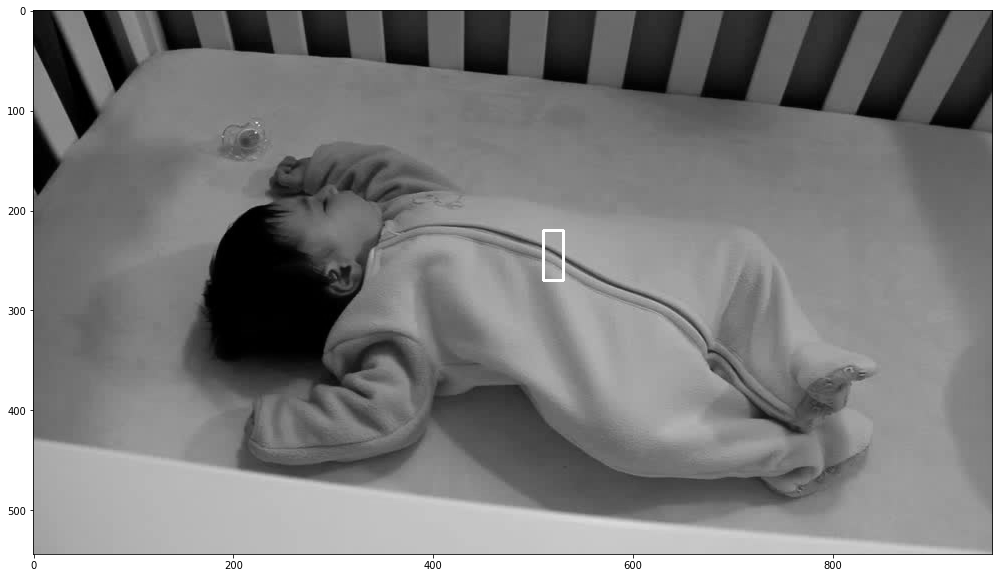

In [80]:
square_coords = {'x1':220, 'x2': 270, 'y1':510, 'y2':530}
draw_roi_nb(video[0].copy(), square_coords)

`base_point` is the base of the vector we draw, it is usually placed in the middle of the ROI.
`amplitude` is the number we multiply the length of the vector for visualization purposes.

In [81]:
base_point = (520, 250)
amplitude = 30

show_optical_flow_roi(video_input, base_point, square_coords, amplitude)
# NOTE: press 'Q' to exit!

#### The colored optical flow visualization

Not really usefull in our case since we have small motions with rapid changes of direction :(
    
But it looks cool

`clip_flow` - clip maximum of flow values, default is `None`. `convert_to_bgr` - cv2 works with BGR

In [82]:
show_optical_flow_color('video_results/auto_learning_based.avi', clip_flow=None, convert_to_bgr=True)
# NOTE: press 'Q' to exit!